In [1]:
#Importing Required Modules or Libraries
import numpy as np
import cv2
import math
import time
from scipy import ndimage
import PIL
import PIL.ImageOps
from PIL import Image
import sys
import json
sys.path.insert(0,r'C:\Users\Engineer Singh\AppData\Local\Programs\Python\Python36\Lib\site-packages')
from mnist import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
#Load Training Data And Testing Data
try:
    del train_images, train_labels
    del test_images, test_labels
    print("cleared loaded data")
except:
    pass

mndata = MNIST("D:\\Project to work\\Project data\\samples\\")
train_images, train_labels = mndata.load_training()
#print(mndata.display(images[0]))  #To display image
#print(labels[0])  #To display label of image

#Load Testing Data
test_images, test_labels = mndata.load_testing()
#print(mndata.display(test_images[0]))  #To display image
#print(test_labels[0])  #To display label of image

In [3]:
#convert Training And Testing Data into arrays
try:
    del X_train,y_train
    del X_test,y_test
    print('Clear previously loaded data.')
except:
    pass
X_train = np.array(train_images).astype(float)
y_train = np.array(train_labels)
X_test = np.array(test_images).astype(float)
y_test = np.array(test_labels)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (60000, 784)
Train labels shape:  (60000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


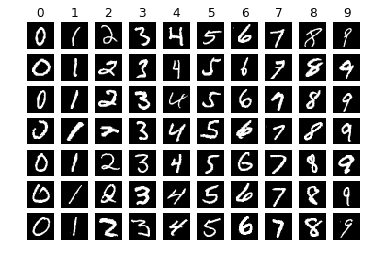

In [4]:
#Display Sample Trainig Data before preprocessing 
"""
by the way Trainig Data is already preprocessed but we again 
preprocess it so to extend this model to our own Testing data
"""
classes = [i for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(28,28).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

In [5]:
#feature extraction

def extract_features(path):
    image = cv2.imread(path,0)
    img = Image.open(path)
    plt.imshow(img)
    plt.show()
    imagecopy = image.copy()
    edged = cv2.Canny(image, 10, 250)
    #cv2.imshow("Edges", edged)
    #cv2.waitKey(0)
    img = Image.fromarray(edged.astype('uint8'))
    plt.imshow(img)
    plt.show()
    #applying closing function 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    #cv2.imshow("Closed", closed)
    #cv2.waitKey(0)
    img = Image.fromarray(closed.astype('uint8'))
    plt.imshow(img)
    plt.show()
    l = []
    bb = []
    idx = 0
    #finding_contours 
    (I, cnts,_) = cv2.findContours(closed.copy(),
                cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bb = []
    for c in cnts:
        bb.append(cv2.boundingRect(c))
    bb.sort()
    #for i, contour in enumerate(cnts):
    #    x, y, w, h = cv2.boundingRect(contour) 
    #    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)
    #cv2.imshow("Output", image)
    #cv2.waitKey(0)
    charNo=0
    for i in bb:
        charNo += 1
        x,y,w,h = i
        new_img = image[y:y+h, x:x+w]
        img1 = Image.fromarray(new_img.astype('uint8'))
        l.append(process_img(img1))
        plt.subplot(10, 10, charNo)
        plt.imshow(img1)
    plt.show()
    return l

#process extracted features

def process_img(path):
    #img = Image.open(path)
    #plt.imshow(img)
    #plt.show()
    img = path
    img = img.convert('L')
    #plt.imshow(img)
    #plt.show()
    img = PIL.ImageOps.invert(img)
    #plt.imshow(img)
    #plt.show()
    ar = np.asarray(img)
    #print(ar.shape)
    v = ar.shape[0]
    h = ar.shape[1]
    m = abs(v-h)//2
    if v >= h:
        ar = np.hstack([ar, np.zeros((ar.shape[0], m))])
        ar = np.hstack([np.zeros((ar.shape[0], m)),ar])
    else:
        ar = np.vstack([ar, np.zeros((m,ar.shape[1]))])
        ar = np.vstack([np.zeros((m,ar.shape[1])),ar])
    #print(ar.shape)
    im = Image.fromarray(ar.astype('uint8'),mode='L')
    #plt.imshow(im,cmap='gray')
    #plt.show()
    im = im.resize((20,20),resample=PIL.Image.LANCZOS)
    #plt.imshow(im,cmap='gray')
    #plt.show()
    img = np.asarray(im)
    img = np.hstack([img, np.zeros((img.shape[0], 4))])
    img = np.hstack([np.zeros((img.shape[0], 4)),img])
    img = np.vstack([img, np.zeros((4,img.shape[1]))])
    img = np.vstack([np.zeros((4,img.shape[1])),img])
    #plt.imshow(img.astype('uint8'),cmap='gray')
    #plt.show()
    #print(img.shape)
    return img

In [6]:
# Function for Preprocessing of Image array
def process_arr(arr):
    or_shape = arr.shape
    arr = arr.reshape((28,28))
    iminv = Image.fromarray(arr.astype('uint8'))
    left,upper,right,lower = iminv.getbbox()
    aa = arr[upper:lower , left:right]
    ar = np.asarray(aa)
    #print(ar.shape)
    v = ar.shape[0]
    h = ar.shape[1]
    m = abs(v-h)//2
    if v >= h:
        ar = np.hstack([ar, np.zeros((ar.shape[0], m))])
        ar = np.hstack([np.zeros((ar.shape[0], m)),ar])
    else:
        ar = np.vstack([ar, np.zeros((m,ar.shape[1]))])
        ar = np.vstack([np.zeros((m,ar.shape[1])),ar])
    im = Image.fromarray(ar.astype('uint8'),mode='L')
    im = im.resize((20,20),resample=PIL.Image.LANCZOS)
    img = np.asarray(im)
    img = np.hstack([img, np.zeros((img.shape[0], 4))])
    img = np.hstack([np.zeros((img.shape[0], 4)),img])
    img = np.vstack([img, np.zeros((4,img.shape[1]))])
    img = np.vstack([np.zeros((4,img.shape[1])),img])
    return img.reshape(or_shape)

In [7]:
#Preprocessing of Image array
for i in range(len(X_train)):
    X_train[i] = process_arr(X_train[i])
for i in range(len(X_test)):
    X_test[i] = process_arr(X_test[i])

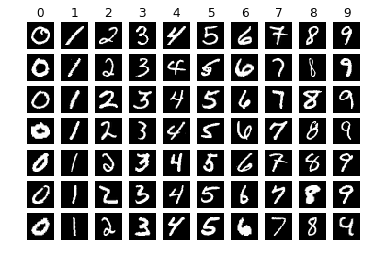

In [8]:
#Display Sample Trainig Data after preprocessing 
classes = [i for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(28,28).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

In [9]:
#Subsampling Data for training , validation and Testing
num_training = 50000
num_validation = 10000
num_test = 10000
mask = list(range(num_training, num_training + num_validation))
X_val = X_train[mask]
y_val = y_train[mask]
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
    
# Normalize the data: subtract the mean image
#mean_image = np.mean(X_train, axis = 0)
#X_train -= mean_image
#X_val -= mean_image
#X_test -= mean_image
    
# add bias dimension and transform into columns (for softmax)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 785)
Train labels shape:  (50000,)
Validation data shape:  (10000, 785)
Validation labels shape:  (10000,)
Test data shape:  (10000, 785)
Test labels shape:  (10000,)


In [10]:
#Softmax loss functions
def softmax_loss_naive(W, X, y, reg):
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    num_classes = W.shape[1]
    num_train = X.shape[0]

    for i in range(num_train):

        # loss
        scores = X[i].dot(W)
        # shift values for 'scores' for numeric reasons (over-flow cautious)
        scores -= scores.max()
        scores_expsum = np.sum(np.exp(scores))
        cor_ex = np.exp(scores[y[i]])
        loss += - np.log( cor_ex / scores_expsum)

        # grad
        # for correct class
        dW[:, y[i]] += (-1) * (scores_expsum - cor_ex) / scores_expsum * X[i]
        for j in range(num_classes):
            # pass correct class gradient
            if j == y[i]:
                continue
            # for incorrect classes
            dW[:, j] += np.exp(scores[j]) / scores_expsum * X[i]

    loss /= num_train
    loss += reg * np.sum(W * W)
    dW /= num_train
    dW += 2 * reg * W
    return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    num_classes = W.shape[1]
    num_train = X.shape[0]
    # loss
    # score: N by C matrix containing class scores
    scores = X.dot(W)
    scores -= scores.max()
    scores = np.exp(scores)
    scores_sums = np.sum(scores, axis=1)
    cors = scores[range(num_train), y]
    loss = cors / scores_sums
    loss = -np.sum(np.log(loss))/num_train + reg * np.sum(W * W)
    # grad
    s = np.divide(scores, scores_sums.reshape(num_train, 1))
    s[range(num_train), y] = - (scores_sums - cors) / scores_sums
    dW = X.T.dot(s)
    dW /= num_train
    dW += 2 * reg * W
    return loss, dW


In [11]:
#Linear classifier class
class LinearClassifier(object):
    def __init__(self,W=None):
        self.W = W

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=128,learning_rate_decay=0.95, verbose=False):
        num_train, dim = X.shape
        # assume y takes values 0...K-1 where K is number of classes
        num_classes = np.max(y) + 1  
        if self.W is None:
            # initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)
            
        iterations_per_epoch = max(num_train / batch_size, 1)
        # Run stochastic gradient descent to optimize W
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        for it in range(num_iters):
            # randomize indices
            batch_ind = np.random.choice(num_train, batch_size)
            X_batch = X[batch_ind]
            y_batch = y[batch_ind]
            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            # perform parameter update
            self.W += - learning_rate * grad
            if verbose and it % 1000 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))
                # Every epoch, check train and val accuracy and decay learning rate.
            if it % 1000 == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

        return loss_history

    def predict(self, X):

        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis=1)
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        pass

class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [12]:
#Load pretrained parameters if available
with open('project_weights_softmax.json','r') as f:
    W = np.array(json.load(f))
W.shape

(785, 10)

In [13]:
#Initialise Softmax
#learnng rate and regularization
lr = 1e-7
reg = 5e2

# if has pretrained weights
softmax = Softmax(W)

#for random weights
#softmax = Softmax()

In [14]:
# Train the network
tic = time.time()
stats = softmax.train(X_train, y_train, learning_rate=lr,
                      reg=reg, num_iters= 10000,verbose=True)
toc = time.time()
print('Training Time {0}s'.format(toc - tic))
y_train_pred = softmax.predict(X_train)
acc_train = np.mean(y_train == y_train_pred)

y_val_pred = softmax.predict(X_val)
acc_val = np.mean(y_val == y_val_pred)
    
# Print out results.
train_accuracy, val_accuracy = acc_train, acc_val
print("train accuracy: ",train_accuracy)
print("val_accuracy: ",val_accuracy)
# evaluate on test set
y_test_pred = softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Test accuracy: ',test_accuracy)

iteration 0 / 10000: loss 0.551511
iteration 1000 / 10000: loss 0.726093
iteration 2000 / 10000: loss 0.727257
iteration 3000 / 10000: loss 0.741688
iteration 4000 / 10000: loss 0.733801
iteration 5000 / 10000: loss 0.654920
iteration 6000 / 10000: loss 0.592437
iteration 7000 / 10000: loss 0.575129
iteration 8000 / 10000: loss 0.671456
iteration 9000 / 10000: loss 0.616626
Training Time 27.284231662750244s
train accuracy:  0.8869
val_accuracy:  0.9021
Test accuracy:  0.8971


In [15]:
#with open('project_weights_softmax.json','w') as f:
#    json.dump(softmax.W.tolist(),f)

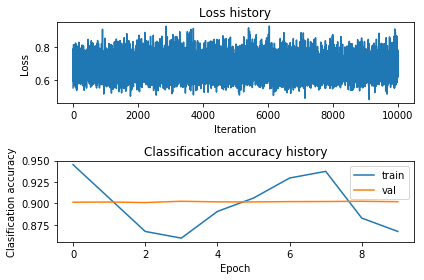

In [15]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend(loc='best')
plt.tight_layout()

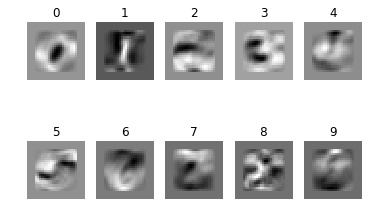

In [16]:
# Visualize the learned weights for each class
w = softmax.W[:-1,:] # strip out the bias
w = w.reshape(28, 28, 1, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

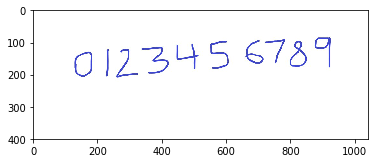

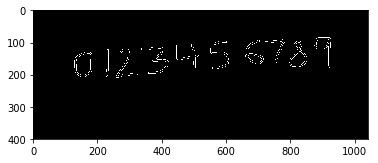

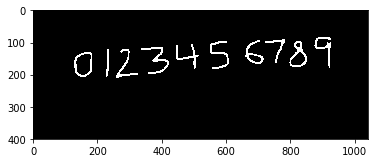

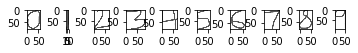

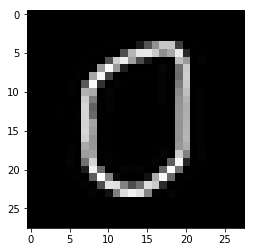

(28, 28)
(1, 785)
Label perdicted -> 0


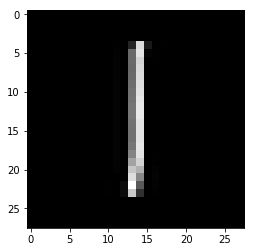

(28, 28)
(1, 785)
Label perdicted -> 1


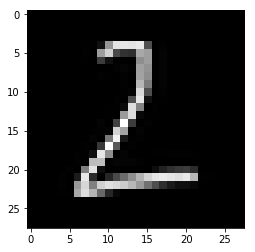

(28, 28)
(1, 785)
Label perdicted -> 2


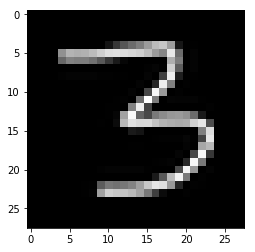

(28, 28)
(1, 785)
Label perdicted -> 3


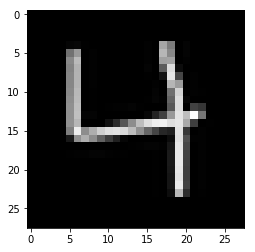

(28, 28)
(1, 785)
Label perdicted -> 4


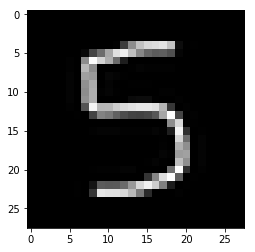

(28, 28)
(1, 785)
Label perdicted -> 3


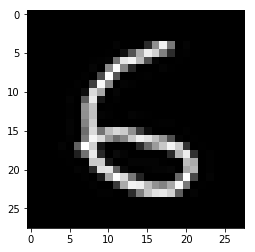

(28, 28)
(1, 785)
Label perdicted -> 6


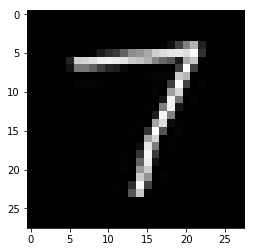

(28, 28)
(1, 785)
Label perdicted -> 7


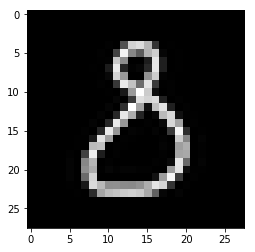

(28, 28)
(1, 785)
Label perdicted -> 3


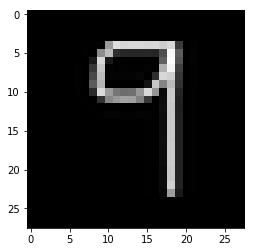

(28, 28)
(1, 785)
Label perdicted -> 9


In [20]:
#testing our own data
input_image = "D://txt.jpg"
output = []

l = extract_features(input_image)
for i in l:
    try:
        plt.imshow(i.astype('uint8'),cmap='gray')
        plt.show()
        print(i.shape)
        i = i.reshape(-1).tolist()
        #append 1 for bias trick for svm and softmax
        i.append(1)
        t = np.array(i)
        t = t.reshape(1,-1).astype(float)
        print(t.shape)
        t = softmax.predict(t)
        output.append(t[0])
        print('Label perdicted ->',t[0])
    except:
        pass

0 1 2 3 4 3 6 7 3 9 


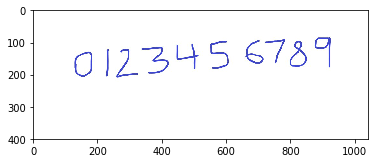

In [21]:
plt.imshow(Image.open(input_image))
out = ''
for i in output:
    out += str(i)+' '
print(out)

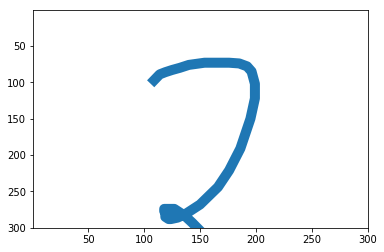

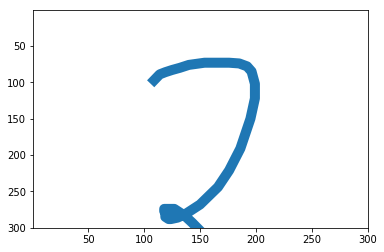

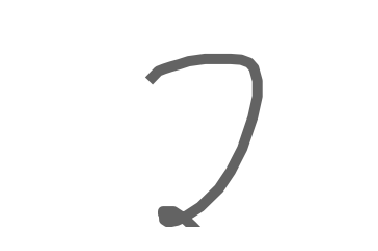

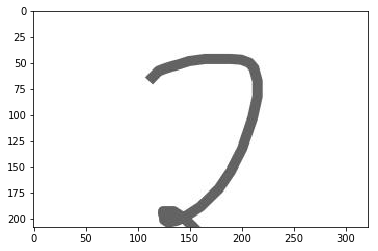

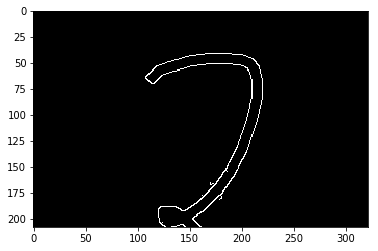

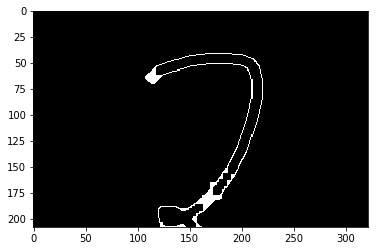

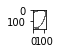

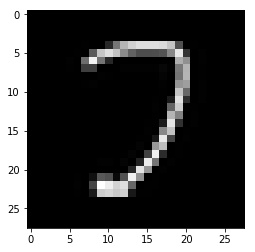

(28, 28)
(1, 785)
Label perdicted -> 3
[3]


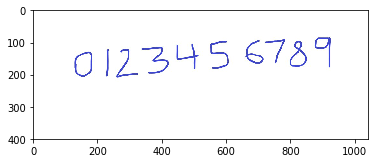

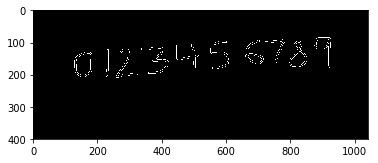

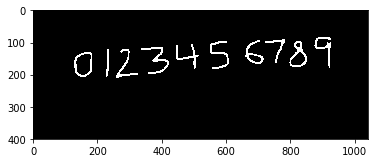

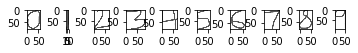

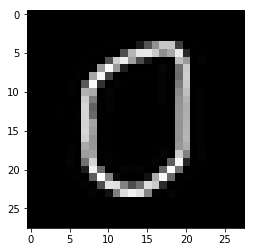

(28, 28)
(1, 785)
Label perdicted -> 0


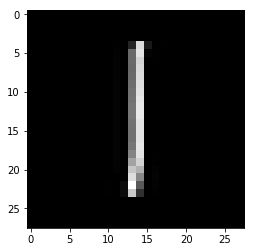

(28, 28)
(1, 785)
Label perdicted -> 1


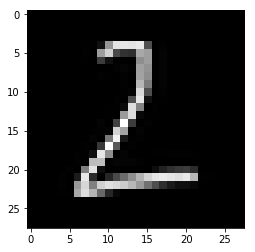

(28, 28)
(1, 785)
Label perdicted -> 2


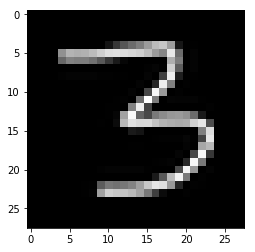

(28, 28)
(1, 785)
Label perdicted -> 3


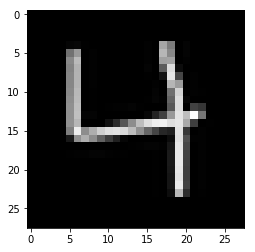

(28, 28)
(1, 785)
Label perdicted -> 4


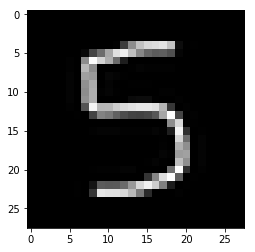

(28, 28)
(1, 785)
Label perdicted -> 3


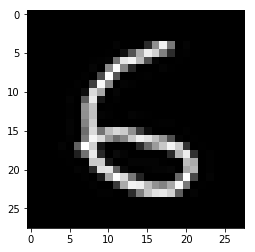

(28, 28)
(1, 785)
Label perdicted -> 6


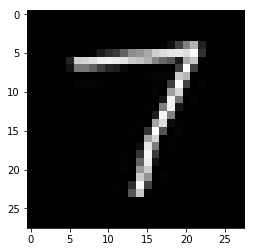

(28, 28)
(1, 785)
Label perdicted -> 7


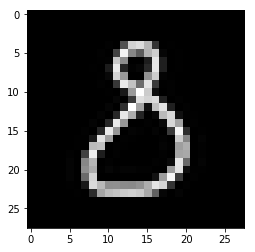

(28, 28)
(1, 785)
Label perdicted -> 3


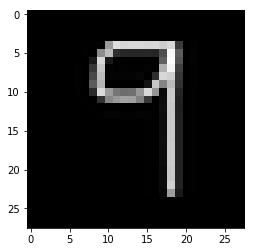

(28, 28)
(1, 785)
Label perdicted -> 9
[0, 1, 2, 3, 4, 3, 6, 7, 3, 9]


In [24]:
from tkinter import Tk, Label, Entry, Button, Canvas, filedialog ,Menu, messagebox
import tkinter 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL.Image, PIL.ImageTk
from PIL import Image, ImageTk

class editor:
    def __init__(self):
        self.root = Tk()
        self.root.title("Handwritten Character Recognition")
        self.xx,self.yy = [],[]
        self.file = None
    def save_image(self,x,y):
        plt.ylim(300,1)
        plt.xlim(1,300)
        plt.plot(x,y,linewidth=10)
        plt.show()
        # make an agg figure
        fig, ax = plt.subplots()
        plt.ylim(300,1)
        plt.xlim(1,300)
        ax.plot(x,y,linewidth=10)
        fig.canvas.draw()
        # grab the pixel buffer and dump it into a numpy array
        X = np.array(fig.canvas.renderer._renderer)
        # now display the array X as an Axes in a new figure
        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111, frameon=False)
        im = Image.fromarray(X)
        im = im.convert('L')
        arr = np.asarray(im)
        arr2 = arr[40:-40,60:-50]
        im = Image.fromarray(arr2)
        plt.imshow(im)
        plt.axis('off')
        plt.grid(False)
        plt.show()
        im = Image.fromarray(arr2)
        im.save("imm.jpg")
    def motion(self,event):
        #print("Mouse position: (%s %s)" % (event.x, event.y))
        self.can.create_oval(event.x, event.y,event.x+14, event.y+14,fill = 'black',width=10)
        self.xx.append(event.x)
        self.yy.append(event.y)
    def getp(self):
        return self.xx,self.yy
    def resetp(self):
        self.xx,self.yy = [],[]
    def get_label(self):
        return 4
    def exit(self):
        res = messagebox.askyesno('Exit','Are you Sure')
        if res:
            self.root.destroy()
    def clear(self):
        self.can.delete("all")
        self.resetp()
        try:
            self.label.destroy()
            self.file = None
        except:pass
    def perdict(self):
        x,y = self.getp()
        if self.file == None and x[:] == []:
            res = messagebox.showerror('Error','Please Draw or Select an Image')
        else:
            if self.file != None:
                input_image = self.file
            else:
                self.save_image(x,y)
                input_image = 'imm.jpg'
            output = []
            l = extract_features(input_image)
            for i in l:
                try:
                    plt.imshow(i.astype('uint8'),cmap='gray')
                    plt.show()
                    print(i.shape)
                    i = i.reshape(-1).tolist()
                    #append 1 for bias trick for svm and softmax
                    i.append(1)
                    t = np.array(i)
                    t = t.reshape(1,-1).astype(float)
                    print(t.shape)
                    t = softmax.predict(t)
                    output.append(t[0])
                    print('Label perdicted ->',t[0])
                except:
                    pass
            res = messagebox.showinfo('Label','Label Perdicted is: '+str(output[:]))
            print(output)
            self.resetp()
    def labels(self):
        self.lbl = Label(self.root, text="Draw Digit", font=("Arial Bold", 20))
        self.lbl.grid(row=0)
        self.lbl2 = Label(self.root, text=" ", font=("Arial Bold", 10))
        self.lbl2.grid(row=4,column= 0)
    def menus(self):
        menu = Menu(self.root)
        new_item = Menu(menu,tearoff=0)
        new_item.add_command(label='Open File',command = self.open_file)
        menu.add_cascade(label='File', menu = new_item)
        self.root.config(menu=menu)
    def canvases(self):
        self.can = Canvas(self.root, width=300, height=300, bg="white")
        self.can.config(bg='white')
        self.can.bind('<B1-Motion>',self.motion)
        self.can.grid(row=1,column= 0)        
    def buttons(self):
        self.btn = Button(self.root, text="Exit", bg="orange", fg="red",command=self.exit)
        self.btn.grid(row=3,column= 0,sticky= 'E',padx=15,ipadx=10)
        self.btn = Button(self.root, text="Clear Canvas", bg="orange", fg="red",command=self.clear)
        self.btn.grid(row=3,column= 0,sticky= 'W',padx=15,ipadx=10)
        self.btn = Button(self.root, text="Perdict Label", bg="orange", fg="red",command=self.perdict)
        self.btn.grid(row=2,column= 0,sticky='S,N,E,W',padx=15,pady=15)
    def run(self):
        self.labels()
        self.menus()
        self.canvases()
        self.buttons()
        self.root.mainloop()
    def open_file(self):
        self.file = filedialog.askopenfilename(filetypes = (("jpg","*.jpg"),("all files","*.*")))
        if self.file:
            self.can.delete("all")
        images = Image.open(self.file)
        #images= images.resize((640, 480), PIL.Image.ANTIALIAS)
        img = ImageTk.PhotoImage(images)
        self.label = Label(self.root, image=img)
        self.label.img = img
        self.label.grid(column=0,row=1)
edit = editor()
edit.run()